In [1]:
import os
import pyro
import torch
import pickle
import time

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pyro.distributions as dist

from torch import Tensor
from tqdm.auto import trange
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive
from pyro.distributions import constraints
from pyro.infer.autoguide import AutoDiagonalNormal

os.chdir("../../")

from src.dgp_rff.deep_layer import DeepGP, DeepGPNoBias

In [2]:
import torch
torch.cuda.is_available()
# trouble shoot see this link:https://stackoverflow.com/questions/77068908/how-to-install-pytorch-with-cuda-support-on-windows-11-cuda-12-no-matching

True

In [3]:
start = time.perf_counter()
torch.cuda.current_device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
# cuda = torch.device('cuda') 

In [4]:
var1= torch.FloatTensor([1.0,2.0,3.0]).cuda()

In [5]:
var1.device

device(type='cuda', index=0)

In [6]:
torch.cuda.memory_allocated()

512

  # Next step

0. Get familiar with the coding structure
1. CPU -> GPU
2. Last step without bias
3. Figure out how they train
4. How to access the posterior mean and std/scale from the model
5. Learn pickle: numpy.ndarray, png
6. ....
7. construct a DeepGP class

In [7]:
# Set random seed for reproducibility
np.random.seed(1)

# Read data
cwd = os.getcwd()
print(cwd)

X_train_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_X_train.txt")
X_test_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_X_test.txt")
Y_train_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_Y_train.txt")
Y_test_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_Y_test.txt")

x_obs = np.loadtxt(X_train_path)
y_obs = np.loadtxt(Y_train_path)
x_val = np.loadtxt(X_test_path)
y_val = np.loadtxt(Y_test_path)

# Set plot limits and labels
xlims = [-0.2, 0.2]

# The X and Y have to be at least 2-dim
x_train = torch.from_numpy(x_obs).float().reshape(-1,1)
y_train = torch.from_numpy(y_obs).float()
x_test = torch.from_numpy(x_val).float().reshape(-1,1)
y_test = torch.from_numpy(y_val).float()

C:\Users\yuanq\OneDrive\Desktopold\SB\research\DGPII\program\DGP-RFF-main


In [8]:
x_train = x_train.cuda()


In [9]:
y_train = y_train.cuda()
x_test = x_test.cuda()
y_test = y_test.cuda()

In [10]:
x_train.device

device(type='cuda', index=0)

In [11]:


  # X = [
#     [1,2,3],
#     [4,5,6,7,8]
#     ]
# X_path = os.path.join(cwd, "folds", "test.pickle")
# with open(X_path, 'wb') as f:
#     pickle.dump(X, f)

In [12]:
# with open(X_path, 'rb') as f:
#     X_read = pickle.load(f)

In [13]:
class Model(PyroModule):
    def __init__(self, in_dim_list=[1,1], out_dim_list=[1,1], J_list=[50,10]):
        super().__init__()
        
        self.out_dim = out_dim_list[-1]
        self.model = DeepGP(in_dim_list, out_dim_list, J_list)
        self.model.to('cuda')

    def forward(self, x, y=None):
        mu = self.model(x).squeeze() #10000*6
        
        # batch shape | event shapt
        # 10000       |
        
        scale = pyro.sample("sigma", dist.Gamma(torch.tensor(0.5, device='cuda'), torch.tensor(1.0, device='cuda'))).expand(self.out_dim)  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]): # x.shape[0]=10000
            # obs = xxx("obs", mu, obs=y)
            obs = pyro.sample("obs", dist.MultivariateNormal(mu.cuda(), torch.diag(scale * scale).cuda()), obs=y)
            
#         f1: phi(Omega x)W (+ epsilon1)
#         f2: phi(Omega f1)W (+ epsilon2)
        
#         f2 + epsilon ~ N(0, Sigma)
            
        return mu

In [14]:
model = Model(in_dim_list=[x_train.shape[1],10], out_dim_list=[10,y_train.shape[1]], J_list=[50,10])
print(x_train.shape)
print(y_train.shape)
model = model.to('cuda')

[FirstLayer(
  (layer): PyroLinear(in_features=1, out_features=50, bias=False)
), SecondLayer(
  (layer): PyroLinear(in_features=100, out_features=10, bias=True)
), FirstLayer(
  (layer): PyroLinear(in_features=10, out_features=10, bias=False)
), SecondLayer(
  (layer): PyroLinear(in_features=20, out_features=6, bias=True)
)]
torch.Size([10000, 1])
torch.Size([10000, 6])


不容易debug，下拉框啥也没有，猜着de

In [15]:
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 25000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/25000 [00:00<?, ?it/s]

In [16]:
model.parameters()

<generator object Module.parameters at 0x0000018F0F6DE340>

In [17]:
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_test)

In [18]:
y_pred = preds['obs'].cpu().detach().numpy().mean(axis=0)

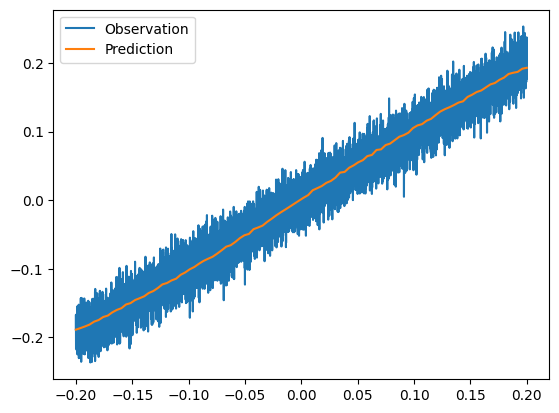

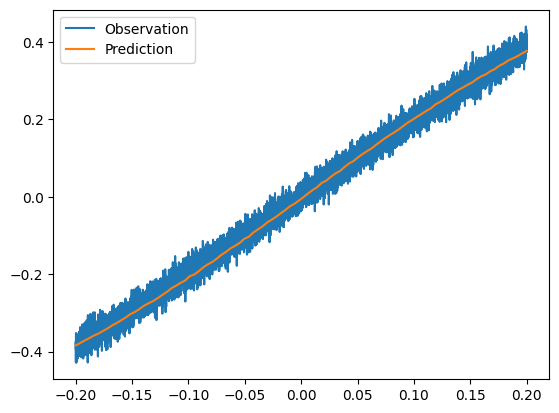

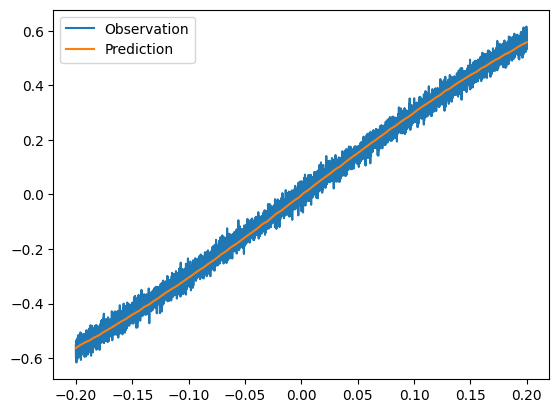

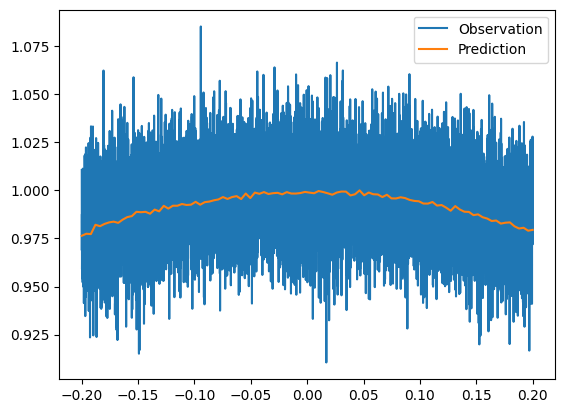

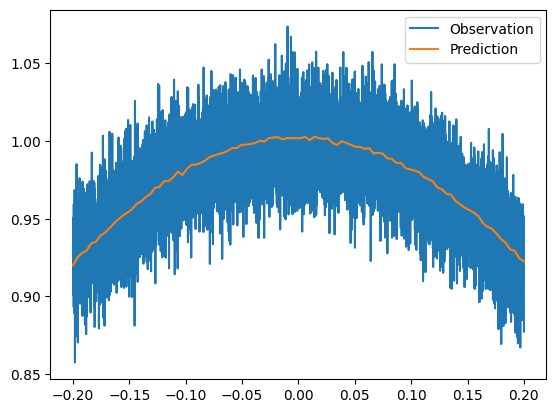

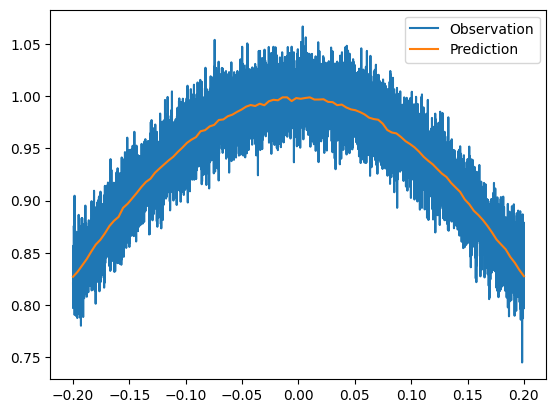

In [19]:
for d in range(6):
    plt.plot(x_obs, y_obs[:,d], label="Observation")
    plt.plot(x_test.cpu(), y_pred[:,d], label="Prediction")
    plt.legend()
    plt.show()

In [20]:
# sampled Omega: 
for i in range(int(len(model.model.layers)/2)):
    print("Layer", 2*i, " and Layer", 2*i+1, ":")
    print("Omega = ", model.model.layers[2*i].layer.weight.squeeze())
    print("W = ", model.model.layers[2*i+1].layer.weight.squeeze())
    print("bias = ", model.model.layers[2*i+1].layer.bias.squeeze())


Layer 0  and Layer 1 :
Omega =  tensor([ 3.5708e-01,  3.0400e-01,  1.5795e+00, -8.3509e-01, -1.4672e+00,
         9.1107e-01,  6.3120e-01, -2.6084e-01,  6.3433e-01, -1.1226e+00,
         9.2320e-01,  3.5973e-01, -2.4044e-01, -7.7973e-01,  3.1928e-02,
         1.8870e-01, -4.9351e-02,  2.5185e-01,  2.2626e-01, -1.2268e+00,
         2.6194e+00, -1.2716e+00,  3.1114e-01, -1.6416e-02,  6.6878e-01,
         3.6833e-01,  1.4465e+00,  7.5273e-01, -1.4429e+00, -1.2476e+00,
        -1.7203e+00, -2.9809e-01, -1.5633e+00, -5.2497e-01,  1.0364e+00,
         3.7684e-01, -3.2751e-01, -6.1649e-01, -2.2810e-01,  2.0601e+00,
        -2.4591e-01, -9.0166e-01,  2.4551e-03, -4.5890e-01,  1.8187e+00,
         1.2332e+00, -4.1191e-01,  1.6528e+00, -1.1613e+00,  4.4725e-01],
       device='cuda:0')
W =  tensor([[ 8.3934e-01,  4.8715e-01,  1.8740e+00, -1.1427e+00, -6.3717e-01,
         -1.9992e+00, -9.5619e-01,  1.1168e+00,  1.4485e+00,  8.6431e-01,
         -1.3929e+00,  1.7414e+00, -1.4411e+00, -1.4947e-01,

In [21]:
# pickle.dump(model, open('DeepRFGP.model.pkl', 'wb'))

In [22]:
preds['model.layers.0.layer.weight'].squeeze().mean(axis=0)#: Omega estimator

tensor([-1.1904, -1.6683, -1.2386,  1.1107,  1.2499,  1.0817,  0.8204,  1.3366,
         1.0702, -1.1244, -1.2570,  0.9147,  1.1349, -1.8159,  1.4893,  1.4515,
         1.3907,  1.3816,  1.1647, -1.5250,  1.2505,  1.3573,  1.3514, -0.2478,
         1.3096, -1.0036, -0.7069, -1.1728,  1.3236, -1.5400, -1.4044, -0.1928,
         1.2668, -1.6243, -1.3232, -0.3210,  0.8353, -1.3512,  1.1862,  1.3061,
        -1.2525,  0.9878,  0.6595,  1.4036, -1.1288,  1.1587,  1.6464, -1.3130,
         1.0759,  0.0871], device='cuda:0')

In [23]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

AutoDiagonalNormal.loc torch.Size([1287])
AutoDiagonalNormal.scale torch.Size([1287])


In [24]:
model.model.layers[0].layer.weight

tensor([[-1.7294e+00],
        [ 1.5834e+00],
        [-1.2672e-01],
        [ 2.7339e-01],
        [-7.8197e-01],
        [-3.4745e-01],
        [ 2.0558e-01],
        [ 3.0629e-01],
        [ 1.2283e+00],
        [-4.7838e-01],
        [ 1.7172e+00],
        [ 1.5170e+00],
        [-1.2505e-01],
        [ 1.0929e+00],
        [-1.8289e-01],
        [ 1.4738e+00],
        [-9.3819e-01],
        [ 5.9841e-02],
        [-2.2860e-01],
        [-1.5895e+00],
        [ 1.1343e+00],
        [-2.8143e-02],
        [-8.4357e-01],
        [ 9.4543e-01],
        [-1.6612e-01],
        [-9.9031e-01],
        [-8.1163e-01],
        [-1.9622e+00],
        [ 1.3941e+00],
        [ 7.7484e-01],
        [ 1.7026e-01],
        [-1.7251e-02],
        [ 9.8828e-01],
        [ 1.1246e+00],
        [-1.3071e+00],
        [ 1.0557e+00],
        [-1.6253e+00],
        [ 5.7578e-01],
        [ 2.1699e-01],
        [-8.4780e-01],
        [-5.9019e-01],
        [ 5.9755e-01],
        [ 2.0096e-03],
        [ 9

In [25]:
end = time.perf_counter()
runtime = end - start
print("Runtime:", runtime)

Runtime: 722.341921199928


1 -> 50; 100 -> 6

Omega 1*50  1*50
W     6*100 6*100
bias  6     6
sigma 1     1

In [26]:
# def model(data):
#   alpha = torch.tensor(6.0)
#   beta = torch.tensor(10.0)
#   pay_probs = pyro.sample('pay_probs', dist.Beta(alpha, beta).expand(3).independent(1))
#   normalized_pay_probs = pay_probs / torch.sum(pay_probs)

#   with pyro.iarange('data_loop', len(data)):
#     pyro.sample('obs', dist.Categorical(probs=normalized_pay_probs), obs=data)

In [27]:
# def guide(data):
#   alphas = pyro.param('alphas', torch.tensor(6.).expand(3), constraint=constraints.positive)
#   betas = pyro.param('betas', torch.tensor(10.).expand(3), constraint=constraints.positive) 

#   pyro.sample('pay_probs', dist.Beta(alphas, betas).independent(1))